In [1]:
# ! pip install git+https://github.com/huggingface/transformers accelerate

In [2]:
# ! pip install qwen-vl-utils[decord]==0.0.8

In [3]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [4]:
import torch
# We recommend enabling flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-7B-Instruct",
    torch_dtype=torch.float16,
    # attn_implementation="flash_attention_2",
    device_map="auto",
)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [5]:
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct")

In [6]:
def infer(model, file_path, max_tokens=1024):
    messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "resized_height": 640,
                "resized_width": 640,
                "image": f"file://{file_path}"
            },
            {"type": "text", "text": """Extract the line items from the invoice and return in the following format
            {"line_items": [
                {"item_name": "", "item_quantity": "", "item_value": ""},
                {"item_name": "", "item_quantity": "", "item_value": ""}
                ]
            """},
        ],
    }]
    text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True)

    image_inputs, video_inputs = process_vision_info(messages)
    
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt"
    )
    inputs = inputs.to("cuda")
    generated_ids = model.generate(**inputs, max_new_tokens=max_tokens)

    # Inference: Generation of the output
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    return output_text
    

    

In [7]:
infer(model, "/workspace/invoice_test_2.jpg")

['\n addCriterion\n            {"line_item": [\n                {"item": "SPGTHY BOLDGNASE", "quantity": "1", "value": "58,000"},\n                {"item": "PEPPER AUS WELL DONE", "quantity": "1", "value": "165,000"},\n                {"item": "WAGYU RIBEYE MEDIUM WELL", "quantity": "1", "value": "195,000"},\n                {"item": "ICED LEMON TEA", "quantity": "1", "value": "22,000"},\n                {"item": "FUSION TEA LYCHEE", "quantity": "1", "value": "28,000"},\n                {"item": "NUTTELA BROWNIES", "quantity": "1", "value": "35,000"}\n            ]}\n']

In [8]:
# ! pip install datasets

In [9]:
from datasets import load_dataset
dataset = load_dataset("mychen76/invoices-and-receipts_ocr_v2")

In [10]:
val_dataset = dataset["valid"].to_pandas()
val_dataset

image  id  \
0    {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   0   
1    {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   1   
2    {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...  10   
3    {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...  11   
4    {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...  12   
..                                                 ...  ..   
165  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   5   
166  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   6   
167  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   7   
168  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   8   
169  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   9   

                                           parsed_data  \
0    {"xml": "", "json": "\"{\\\"line_items\\\": [{...   
1    {"xml": "", "json": "\"{\\\"line_items\\\": {\...   
2    {"xml": "", "json": "\"{\\\"line_items\\\": [{...   
3    {"xml": "", "json": "\"{\\\"line_items\\\": [{...   
4    {"xml": "", "json": "\"{\\\"line_items\\\": {\...   
..                                                 ...   
165  {"xml": "<s_receipt><s_total>200.36 200.36</s_...   
166  {"xml": "<s_receipt><s_total>70.34</s_total><s...   
167  {"xml": "<s_receipt><s_total></s_total><s_tips...   
168  {"xml": "<s_receipt><s_total>\u00a323.95</s_to...   
169  {"xml": "<s_receipt><s_total>$69.60</s_total><...   

                                              raw_data  
0    {"ocr_words": "['1 REAL GANACHE', '16,500', '1...  
1    {"ocr_words": "['404', 'Kopi Susu Kolone1', '2...  
2    {"ocr_words": "['2', 'Serbu 1', '40.000', '2',...  
3    {"ocr_words": "[\"Se'I Sapi Sambal Matah R1\",...  
4    {"ocr_words": "['ES KOPI SUSU4', '72.000', 'To...  
..                                                 ...  
165  {"ocr_words": "['SWHOLESALE', 'RICHMONDCA#482'...  
166  {"ocr_words": "['COSTCO', 'WHOLESALE', 'OMAHA,...  
167  {"ocr_words": "['COSTCO', 'WHOESALE', 'Costco ...  
168  {"ocr_words": "['Judsons Bar', 'Pock1ington', ...  
169  {"ocr_words": "['Welcome To The', 'Royal Hotel...  

[170 rows x 4 columns]

In [11]:
# write the bytes into `images` directory
from tqdm import tqdm
for index, row in tqdm(val_dataset.iterrows()):
    image_dict = row["image"]
    image_id = row["id"]
    with open(f"images/image_{image_id}.jpg", "wb") as fp:
        fp.write(image_dict["bytes"])
    

170it [00:01, 87.30it/s]


0it [00:00, ?it/s]

Processing image:  /workspace/images/image_0.jpg


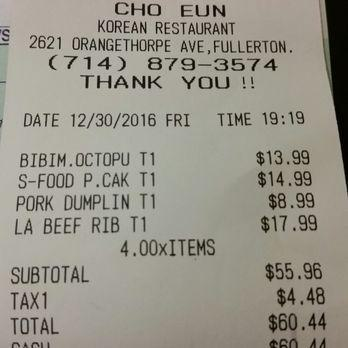

1it [00:06,  6.14s/it]


Prediction:
{'line_items': [{'item': 'BIBIM.OCTOPU T1', 'item_quantity': '', 'item_value': '$13.99'}, {'item': 'S-FOOD P.CAK T1', 'item_quantity': '', 'item_value': '$14.99'}, {'item': 'PORK DUMPLIN T1', 'item_quantity': '', 'item_value': '$8.99'}, {'item': 'LA BEEF RIB T1', 'item_quantity': '', 'item_value': '$17.99'}]}
Processing image:  /workspace/images/image_1.jpg


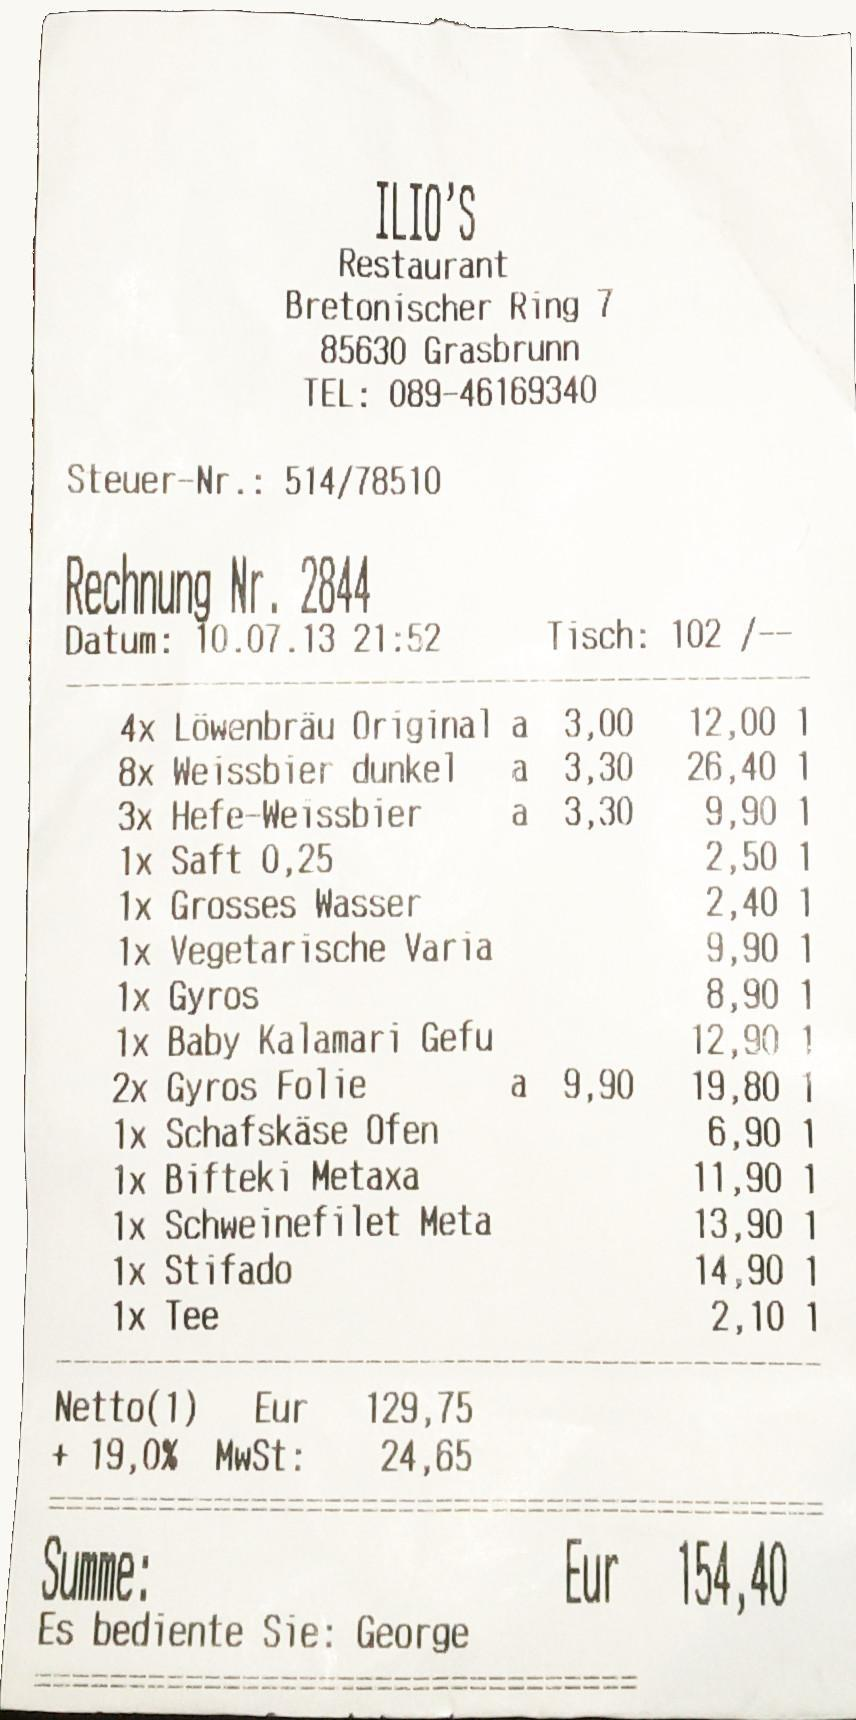

2it [00:24, 13.41s/it]


Prediction:
{'line_items': [{'item_name': 'Löwenbräu Original', 'item_quantity': '4x', 'item_value': '12,00'}, {'item_name': 'Weissbier dunkel', 'item_quantity': '8x', 'item_value': '26,40'}, {'item_name': 'Hefe-Weißbier', 'item_quantity': '3x', 'item_value': '9,90'}, {'item_name': 'Saft 0,25', 'item_quantity': '1x', 'item_value': '2,50'}, {'item_name': 'Grosses Wasser', 'item_quantity': '1x', 'item_value': '2,40'}, {'item_name': 'Vegetarische Varia', 'item_quantity': '1x', 'item_value': '9,90'}, {'item_name': 'Gyros', 'item_quantity': '1x', 'item_value': '8,90'}, {'item_name': 'Baby Kalamari Gefu', 'item_quantity': '1x', 'item_value': '12,90'}, {'item_name': 'Gyros Folie', 'item_quantity': '2x', 'item_value': '19,80'}, {'item_name': 'Schafskäse Ofen', 'item_quantity': '1x', 'item_value': '6,90'}, {'item_name': 'Bifteki Metaxa', 'item_quantity': '1x', 'item_value': '11,90'}, {'item_name': 'Schweinefilet Meta', 'item_quantity': '1x', 'item_value': '13,90'}, {'item_name': 'Stifado', 'it

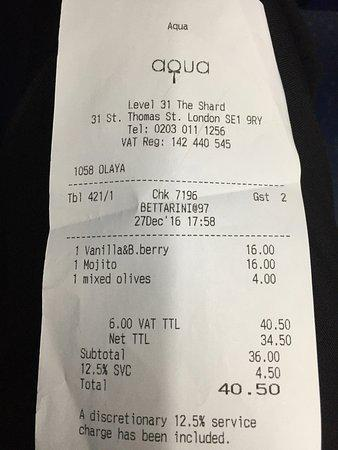

3it [00:28,  8.93s/it]


Prediction:
{'line_item': [{'item_name': 'Vanilla&B.berry', 'item_quantity': '1', 'item_value': '16.00'}, {'item_name': 'Mojito', 'item_quantity': '1', 'item_value': '16.00'}, {'item_name': 'mixed olives', 'item_quantity': '1', 'item_value': '4.00'}]}
Processing image:  /workspace/images/image_11.jpg


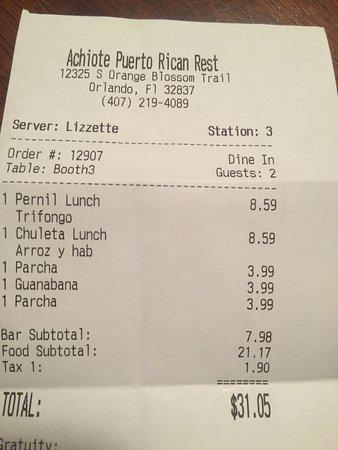

4it [00:34,  7.85s/it]


Prediction:
{'line_items': [{'item': 'Pernil Lunch Trifongo', 'item_quantity': '1', 'item_value': '8.59'}, {'item': 'Chuleta Lunch Arroz y hab', 'item_quantity': '1', 'item_value': '8.59'}, {'item': 'Parcha', 'item_quantity': '1', 'item_value': '3.99'}, {'item': 'Guanabana', 'item_quantity': '1', 'item_value': '3.99'}]}
Processing image:  /workspace/images/image_12.jpg


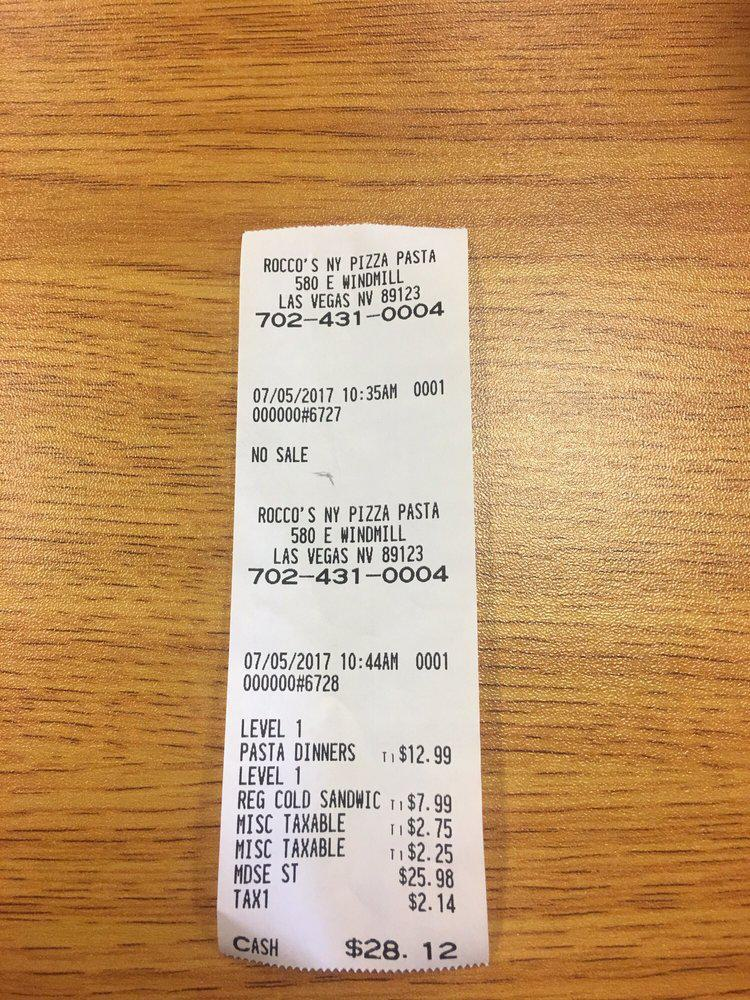

5it [00:41,  7.68s/it]


Prediction:
{'line_items': [{'item': 'PASTA DINNERS', 'item_quantity': '1', 'item_value': '$12.99'}, {'item': 'REG COLD SANDWICH', 'item_quantity': '1', 'item_value': '$7.99'}, {'item': 'MISC TAXABLE', 'item_quantity': '1', 'item_value': '$2.75'}, {'item': 'MISC TAXABLE', 'item_quantity': '1', 'item_value': '$2.25'}, {'item': 'MISC ST', 'item_quantity': '1', 'item_value': '$25.98'}]}
Processing image:  /workspace/images/image_13.jpg


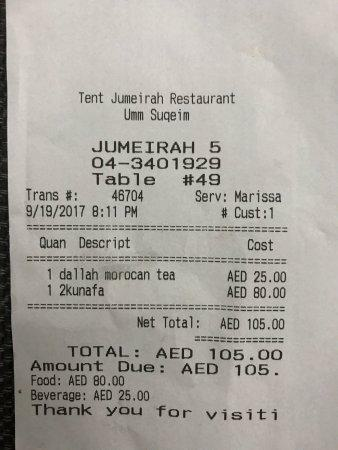

6it [00:44,  6.12s/it]

['\n addCriterion\n            {"line_item": [\n                {"item_name": "dallah morocan tea", "item_quantity": "1", "item_value": "AED 25.00"},\n                {"item_name": "kunafa", "item_quantity": "1", "item_value": "AED 80.00"}\n                ]\n             }\n']
Processing image:  /workspace/images/image_14.jpg


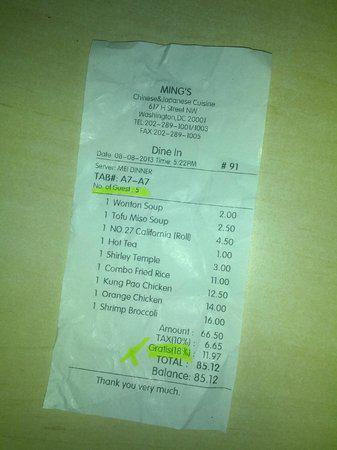

7it [00:56,  7.88s/it]


Prediction:
{'line_items': [{'item_name': 'Wonton Soup', 'item_quantity': '1', 'item_value': '2.00'}, {'item_name': 'Tofu Miso Soup', 'item_quantity': '1', 'item_value': '2.50'}, {'item_name': 'NO 27 California (Roll)', 'item_quantity': '1', 'item_value': '4.50'}, {'item_name': 'Hot Tea', 'item_quantity': '1', 'item_value': '1.00'}, {'item_name': 'Shirley Temple', 'item_quantity': '1', 'item_value': '3.00'}, {'item_name': 'Combo Fried Rice', 'item_quantity': '1', 'item_value': '11.00'}, {'item_name': 'Kung Pao Chicken', 'item_quantity': '1', 'item_value': '12.50'}, {'item_name': 'Orange Chicken', 'item_quantity': '1', 'item_value': '14.00'}, {'item_name': 'Shrimp Broccoli', 'item_quantity': '1', 'item_value': '16.00'}]}
Processing image:  /workspace/images/image_15.jpg


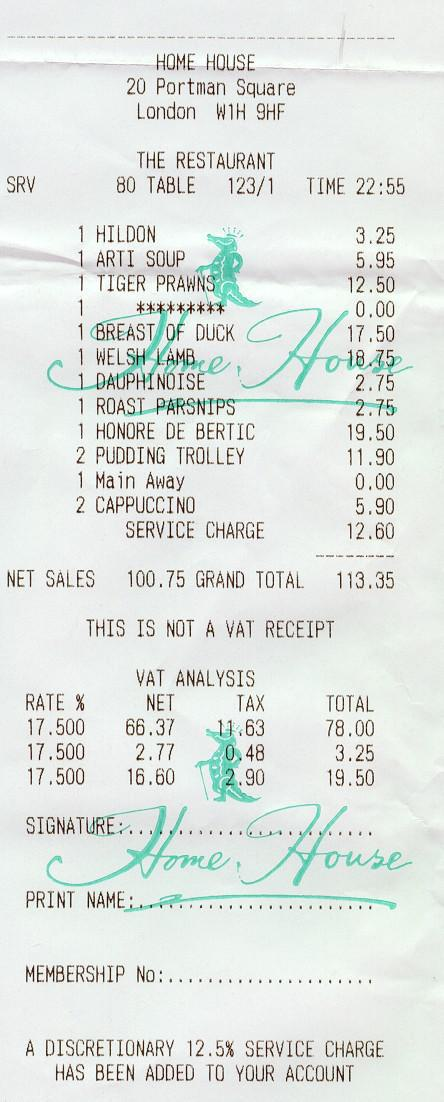

8it [01:06,  8.72s/it]

['\n addCriterion("line_item", [\n                {"item": "HILDON", "quantity": "1", "value": "3.25"},\n                {"item": "ARTI SOUP", "quantity": "1", "value": "5.95"},\n                {"item": "TIGER PRAWNS", "quantity": "1", "value": "12.50"},\n                {"item": "BREAST OF DUCK", "quantity": "1", "value": "17.50"},\n                {"item": "WELSH LAMB", "quantity": "1", "value": "18.75"},\n                {"item": "DAUPHINOISE", "quantity": "1", "value": "2.75"},\n                {"item": "ROAST PARSNIPS", "quantity": "1", "value": "2.75"},\n                {"item": "HONORE DE BERTIC", "quantity": "1", "value": "19.50"},\n                {"item": "PUDDING TROLLEY", "quantity": "2", "value": "11.90"},\n                {"item": "MAIN AWAY", "quantity": "1", "value": "0.00"},\n                {"item": "CAPPUCCINO", "quantity": "2", "value": "5.90"}\n            ])']
Processing image:  /workspace/images/image_16.jpg


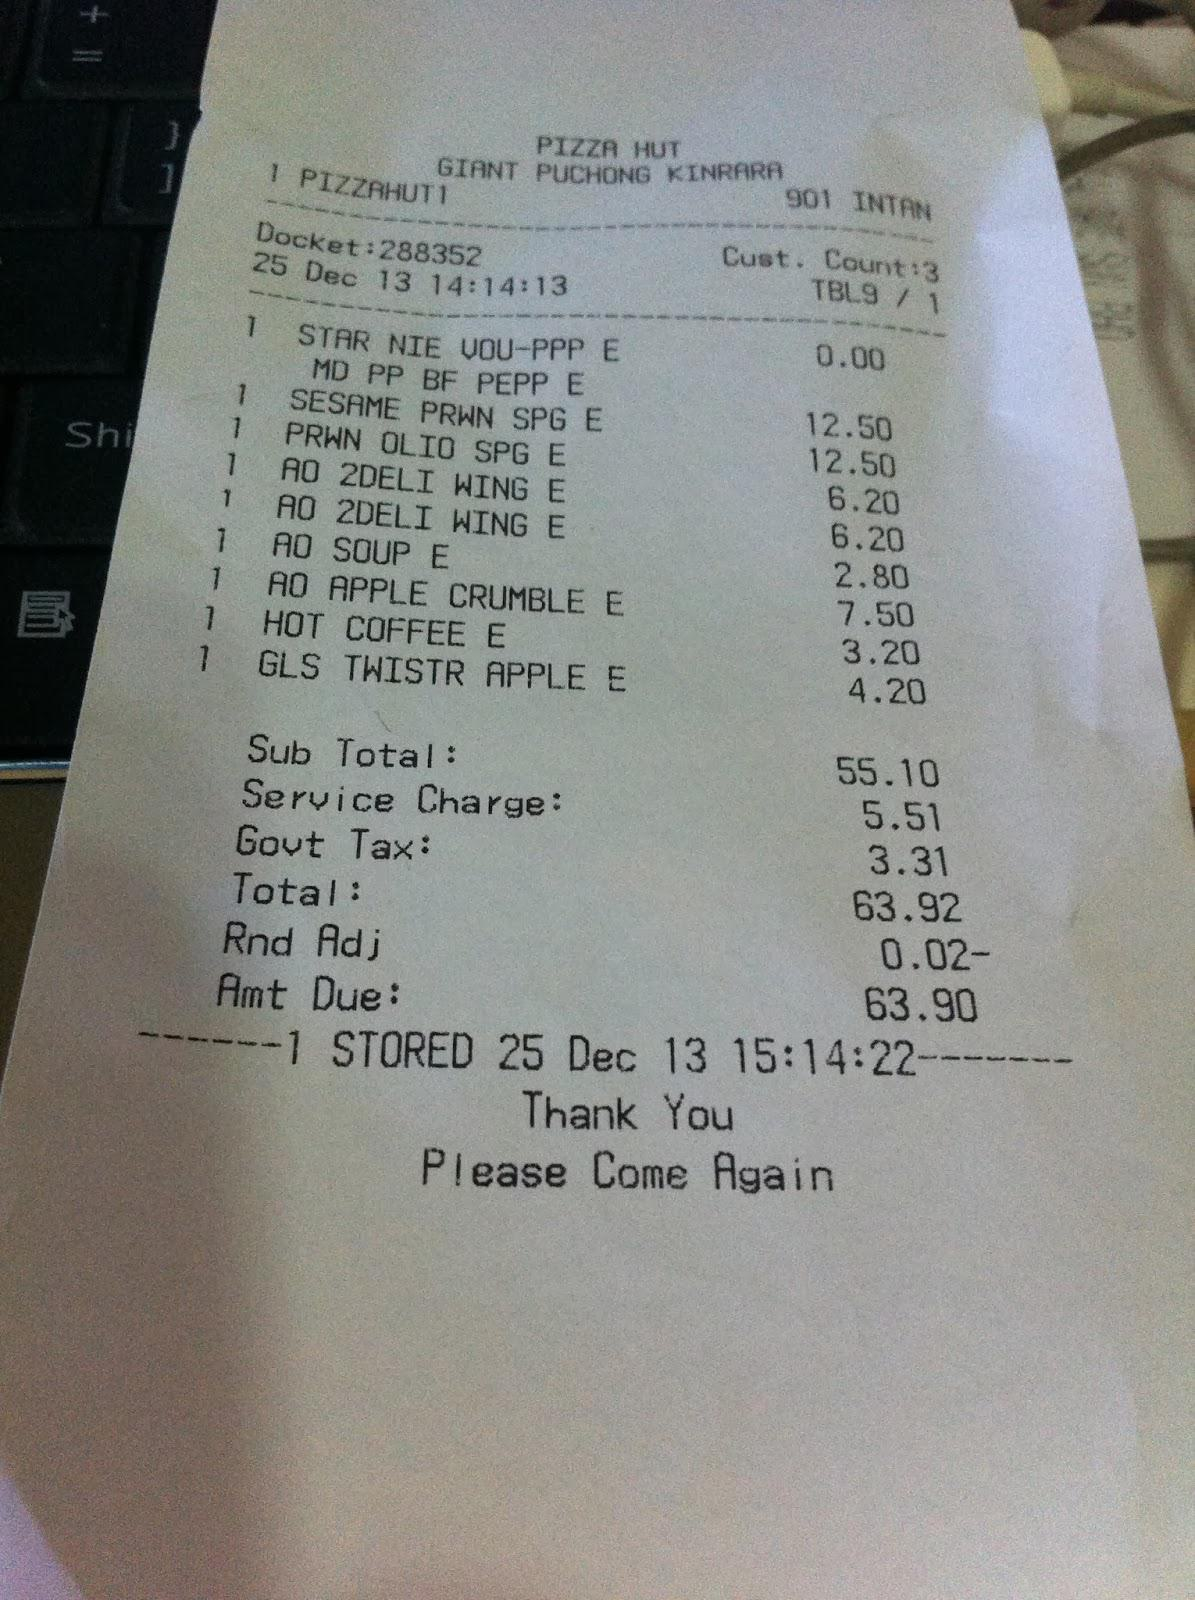

9it [01:16,  9.10s/it]

['\n addCriterion\n            {"line_item": [\n                {"item": "STAR NIE VOU-PPP E", "quantity": "1", "value": "0.00"},\n                {"item": "MD PP BF PEPP E", "quantity": "1", "value": "12.50"},\n                {"item": "SESAME PRWN SPG E", "quantity": "1", "value": "12.50"},\n                {"item": "PRWN OLIOL SPG E", "quantity": "1", "value": "6.20"},\n                {"item": "AO 2DELI WING E", "quantity": "1", "value": "6.20"},\n                {"item": "AO SOUP E", "quantity": "1", "value": "2.80"},\n                {"item": "AO APPLE CRUMBLE E", "quantity": "1", "value": "7.50"},\n                {"item": "HOT COFFEE E", "quantity": "1", "value": "3.20"},\n                {"item": "GLS TWISTR APPLE E", "quantity": "1", "value": "4.20"}\n            ]}\n']
Processing image:  /workspace/images/image_17.jpg


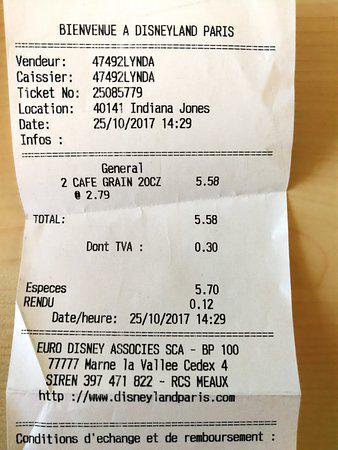

10it [01:19,  7.09s/it]


Prediction:
{'line_item': [{'item': '2 CAFE GRAIN 20CZ', 'item_quantity': '2', 'item_value': '5.58'}, {'item': '@ 2.79', 'item_quantity': '', 'item_value': ''}]}
Processing image:  /workspace/images/image_18.jpg


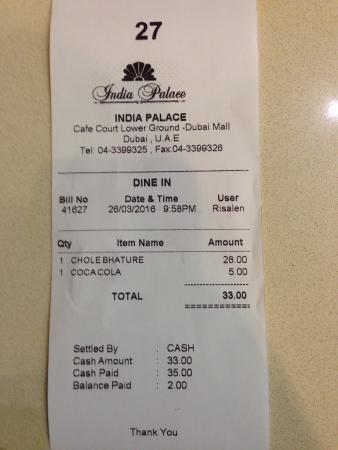

10it [01:22,  8.29s/it]


Prediction:
{'line_items': [{'item_name': 'CHOLE BHATURE', 'item_quantity': '1', 'item_value': '28.00'}, {'item_name': 'COCA COLA', 'item_quantity': '1', 'item_value': '5.00'}]}


In [12]:
import json
import os
from PIL import Image
for index, row in tqdm(val_dataset.iterrows()):
    image_id = row["id"]
    image_path = os.path.join(os.getcwd(), "images", f"image_{image_id}.jpg")
    print("Processing image: ", image_path)
    img = Image.open(image_path)
    img.show()

    # print("Parsed_data: ", row["parsed_data"])
    
    # parsed_data_dict = json.loads(row["parsed_data"])

    response = infer(model, image_path)

    
    try:
        parsed_response = json.loads(response[0].split('```json')[-1].split("```")[0])
    except:
        print(response)
        continue

    print("\nPrediction:")
    print(parsed_response)

    # print("\nGroundTruth:")    
    # print(json.loads(parsed_data_dict["json"]))
    print("=" * 100)
    if index == 10:
        break